<div style="float:right; padding-top: 15px; padding-right: 15px">
    <div>
        <a href="https://whiteboxml.com">
            <img src="https://whiteboxml.com/static/img/logo/black_bg_white.svg" width="250">
        </a>
    </div>
</div>

## 0. python imports

In [1]:
import time

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from IPython import display

In [2]:
tf.__version__

'2.2.0'

## 1. utilities

In [3]:
# data visualization utils

def plot_images_sample(images: np.array = None,
                       labels: np.array = None,
                       path: Path = None,
                       samples: int = 16,
                       figsize: tuple = (8, 8)):
    """
    samples some images from dataset and
    plot a grid of images with its
    corresponding labels
    """

    assert (images is not None and labels is not None) or path

    if path:
        images = [img for img in path.glob('**/*') if img.is_file()]
        labels = [img.parent.name for img in images]

    h = int(np.sqrt(samples))
    w = h

    f, axarr = plt.subplots(h, w, figsize=figsize)

    for i in range(h):
        for j in range(w):
            index = np.random.choice(len(images))
            axarr[i, j].imshow(plt.imread(images[index]) if path else images[index])
            axarr[i, j].set_title(f"class: {labels[index]}")
            axarr[i, j].axis('off')

    plt.tight_layout()
    plt.show()

## 2. settings

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

avoid TF to get all GPU memory...

In [5]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, enable=True)

check for existing gpu resources, if you do not have a gpu, comment the cell below:

In [6]:
!nvidia-smi

Thu Sep 17 20:37:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060    Off  | 00000000:01:00.0  On |                  N/A |
| N/A   52C    P0    27W /  N/A |    332MiB /  6069MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## 3. data loading

Let's load the data using `dataset` package from `keras`...

In [8]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [9]:
train_images.shape

(60000, 28, 28)

In [10]:
train_labels.shape

(60000,)

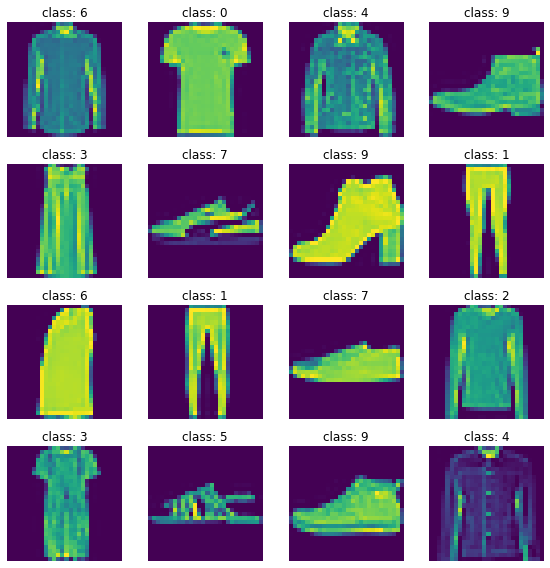

In [11]:
plot_images_sample(images=train_images, labels=train_labels)

## 4. data preprocessing

First, scale pixel values from 0 / 255 to -1 / 1...

In [12]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 255 / 2) / (255 / 2)

Let's create a TensorFlow Dataset object to feed our network...

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
for batch in train_dataset.take(1):
    print(len(batch))

256


## 5. modeling

### 5.1 generator

This network gets a vector of 100 random elements and outputs an images of a number. Output image must have dimensions 28 x 28 x 1... The most interesting thing about the generator are the upsampling `Conv2dTranspose` layers, which perform a transformation opposite to the standard convolution.

In [15]:
def get_generator():
    
    model = tf.keras.Sequential([
        
        # dense upsampling block
        tf.keras.layers.Dense(units=7 * 7 * 256, 
                              use_bias=False, 
                              input_shape=(100,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape((7, 7, 256)),
        
        # 1 conv upsampling block
        tf.keras.layers.Conv2DTranspose(filters=128, 
                                        kernel_size=(5, 5), 
                                        strides=(1, 1), 
                                        padding='same', 
                                        use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        # 2 conv upsampling block
        tf.keras.layers.Conv2DTranspose(filters=64,
                                        kernel_size=(5, 5),
                                        strides=(2, 2),
                                        padding='same',
                                        use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        # 3 upsampling block + output
        tf.keras.layers.Conv2DTranspose(filters=1, 
                                        kernel_size=(5, 5),
                                        strides=(2, 2), 
                                        padding='same',
                                        use_bias=False,
                                        activation=tf.keras.activations.tanh),
    ])
    return model

In [16]:
generator =  get_generator()

In [17]:
generator.input_shape

(None, 100)

In [18]:
generator.output_shape

(None, 28, 28, 1)

In [19]:
generated = generator(np.random.randn(2, 100))

In [20]:
generated.shape

TensorShape([2, 28, 28, 1])

Now, let's define its loss and optimizer. Generator's loss quantifies how well it was able to trick the discriminator. If the generator is performing well, the discriminator will classify the fake images as real (or 1). 

Here, we will compare the discriminators decisions on the generated images to an array of 1s:
* If discriminator outputs 1 (our fake image passed as a real one) -> 1 vs 1
* If discriminator outputs 0 (our fake image was detected as a fake) -> 0 vs 1
* All cases in between...

In [21]:
def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True) \
           (tf.ones_like(fake_output), fake_output)

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 5.2 discriminator

In [23]:
def get_discriminator():
    
    model = tf.keras.Sequential([
        
        # 1 convolution block
        tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=(5, 5),
                               strides=(2, 2),
                               padding='same',
                               use_bias=False, 
                               input_shape=[28, 28, 1]),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Conv2D(filters=128, 
                               kernel_size=(5, 5), 
                               strides=(2, 2), 
                               padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1),
        
    ])

    return model

In [24]:
discriminator = get_discriminator()

In [25]:
discriminator.input_shape

(None, 28, 28, 1)

In [26]:
discriminator.output_shape

(None, 1)

Let's test generator and discriminator networks prior to training... remember that TF 2.0 uses eager execution by default...

In [27]:
discriminator(generated)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.00073695],
       [-0.00033042]], dtype=float32)>

Let's define its loss and optimizer. In this case, loss depends on wether or not the discriminator is able to detect fake from non-fake numbers. This can be expressed as the sum of two losses:
* real loss: number picture is legit -> 1 vs predicted picture is legit (1) or not (0)
* fake loss: number picture is fake -> 0 vs predicted picture is fake (0) or not (1)

In [28]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True) \
                (tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True) \
                (tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [29]:
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## 6. training loop definition

As this is not a standard keras model, but a bit custom one, training must be done manually...

In [30]:
# some training settings

EPOCHS = 64
noise_dim = 100
num_examples_to_generate = 16

In [31]:
# set seed
seed = tf.random.normal([num_examples_to_generate, noise_dim])

Let's define a single train step by hand, using `GradientTape`:

In [32]:
@tf.function
def train_step(images):
    
    # generate random noise
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # use gradient tape
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # generate fake images
        generated_images = generator(noise, training=True)

        # check real images
        real_output = discriminator(images, training=True)
        
        # check fake images
        fake_output = discriminator(generated_images, training=True)

        # compute generator loss
        gen_loss = generator_loss(fake_output)
        
        # compute discriminator loss
        disc_loss = discriminator_loss(real_output, fake_output)

        # compute gradients
        gradients_of_generator = gen_tape.gradient(gen_loss, 
                                                   generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                        discriminator.trainable_variables)

        # update generator and discriminator
        generator_optimizer.apply_gradients(zip(gradients_of_generator, 
                                                generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, 
                                                    discriminator.trainable_variables))

In [33]:
def generate_and_save_images(model, epoch, test_input):
    
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('./images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Now, let's define the full training process:

In [34]:
def train(dataset, epochs):
    
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)


## 7. training

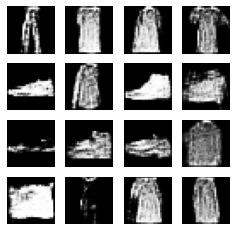

In [35]:
train(train_dataset, EPOCHS)

<div style="padding-top: 25px; float: right">
    <div>    
        <i>&nbsp;&nbsp;© Copyright by</i>
    </div>
    <div>
        <a href="https://whiteboxml.com">
            <img src="https://whiteboxml.com/static/img/logo/black_bg_white.svg" width="125">
        </a>
    </div>
</div>